In [42]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from src.CPQAOA import CP_QAOA
from src.QAOA import QAOA
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       normalized_cost, 
                       qubo_limits, 
                       check_qubo)

In [43]:
# Number of Qubits 
N=6
# number of excitations
k=3
# RNG seed for reproducibility
seed=1
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.5
# Nr. of layer repetitions
layers=1
# Maximal number of iterations for classical solver
max_iter=500
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = False
w_z_phase = False


my_chain = Chain(N_qubits=N)
print(f' Qubit indices in chain: \n', my_chain.get_chain_indexing())
print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_chain.get_NN_indices())
print(f'\n Corresponding Nearest Neighbor + Next Nearest index pairs: \n', my_chain.get_NNN_indices())
init_strat = np.array([0,1,0,1,0,1])
my_chain.set_initialization_strategy(strategy=init_strat)
print(f'\n Initialization strategy is: \n', my_chain.get_initialization_strategy())
print(f'\n Corresponding indices is: \n', my_chain.get_initialization_indices())

# Deciding between grid and 1d chain topology
my_topology = my_chain

 Qubit indices in chain: 
 [0 1 2 3 4 5]

 Corresponding Nearest Neighbor index pairs: 
 [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]

 Corresponding Nearest Neighbor + Next Nearest index pairs: 
 [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5)]

 Initialization strategy is: 
 [0 1 0 1 0 1]

 Corresponding indices is: 
 [1, 3, 5]


In [44]:
# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

# Retrieving C_min, C_max and corresponding states for original portfolio problem
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
full_space_max_cost = full_result['c_max']
portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])
print(f"Min. cost portfolio (constrained subspace): {portfolio_subspace_min_cost}")
print("Optimal portfolio state (constrained subspace) is: |"+portfolio_subspace_min_state_str+">")

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances, 
                     alpha=alpha,
                     lmbda=lmbda+1e-8, # Adding small constant purposely
                     k=k)
QUBO_limits = qubo_limits(Q=Q,offset=offset)
qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])
print(f"Min. cost QUBO: {qubo_min_cost}")
print("Min. cost QUBO state is: |"+qubo_min_state_str+">")
print("Check that qubo min cost is same as portfolio min cost:")
print(qubo_min_cost, portfolio_subspace_min_cost)
print("Check that qubo max cost is at least portfolio max cost:")
print(qubo_max_cost, portfolio_subspace_max_cost)

# Generating instances of ansatz'
CP_z_phase_ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 topology=my_topology,
                 QUBO_matrix=Q,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                 with_gradient=True,
                 approximate_hamiltonian=True,
                 with_z_phase=w_z_phase)

NORMAL_ansatz = QAOA(N_qubits=N,
                 layers=2,
                 QUBO_matrix=Q,
                 QUBO_offset=offset,
                 constraining_mixer=True,
                 Topology=my_topology)

Min. cost portfolio (constrained subspace): 4.931996196739781
Optimal portfolio state (constrained subspace) is: |110010>
Min. cost QUBO: 4.931996196739796
Min. cost QUBO state is: |110010>
Check that qubo min cost is same as portfolio min cost:
4.931996196739796 4.931996196739781
Check that qubo max cost is at least portfolio max cost:
71.68016228241302 8.710003549382588


In [45]:
# Choosing optimizer for scipy
available_methods = ['COBYLA', 'Nelder-Mead', 'BFGS']
optimizer_method = available_methods[2]

# Generating callback function for plotting
CP_z_phase_costs = [] # Normalized costs
CP_z_phase_probs = [] # probability of optimal state
def CP_z_phase_callback_function(x):
    _dict_ = CP_z_phase_ansatz.get_state_probabilities(flip_states=False)
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=portfolio_subspace_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        CP_z_phase_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        CP_z_phase_probs.append(0)
    CP_z_phase_costs.append(_cost_)
    
# Generating callback function for plotting
NORMAL_costs = [] # Normalized costs
NORMAL_probs = [] # probability of optimal state
def NORMAL_callback_function(x):
    _dict_ = NORMAL_ansatz.get_state_probabilities(flip_states=False)
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=portfolio_subspace_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        NORMAL_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        NORMAL_probs.append(0)
    NORMAL_costs.append(_cost_)

# Generating initial guess for rotation angles
np.random.seed(seed)
theta_min, theta_max = -2*np.pi, 2*np.pi
N_angles = layers * len(my_topology.get_NN_indices())
if w_next_nearest_neighbors:
    N_angles = layers * len(my_topology.get_NNN_indices())
if w_z_phase:
    N_angles += N * layers
CP_z_phase_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)

np.random.seed(seed)
N_angles = 2 * 2
NORMAL_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)

In [46]:
CP_z_phase_res = sc.optimize.minimize(fun=CP_z_phase_ansatz.get_cost, 
                                      x0=CP_z_phase_theta_i,
                                      method=optimizer_method,
                                      options={'disp': False, 
                                               'maxiter': max_iter},
                                      callback=CP_z_phase_callback_function)
CP_z_phase_res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -39.45596966391655
        x: [-3.613e-07  3.142e+00 -6.283e+00 -1.571e+00 -4.427e+00]
      nit: 9
      jac: [-2.384e-06 -4.768e-07 -1.907e-06 -1.907e-06  0.000e+00]
 hess_inv: [[ 2.441e-01  4.432e-03 ... -1.864e-03 -1.137e-03]
            [ 4.432e-03  2.248e+00 ... -1.456e-03  1.056e-02]
            ...
            [-1.864e-03 -1.456e-03 ...  3.385e-01  4.863e-03]
            [-1.137e-03  1.056e-02 ...  4.863e-03  9.967e-01]]
     nfev: 66
     njev: 11

In [47]:
NORMAL_res = sc.optimize.minimize(fun=NORMAL_ansatz.get_cost, 
                                      x0=NORMAL_theta_i,
                                      method=optimizer_method,
                                      options={'disp': False, 
                                               'maxiter': max_iter},
                                      callback=NORMAL_callback_function)
NORMAL_res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -36.73791478712081
        x: [-1.043e+00  2.769e+00 -6.282e+00 -2.784e+00]
      nit: 1
      jac: [ 0.000e+00  0.000e+00  4.292e-06  1.589e-01]
 hess_inv: [[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
            [ 0.000e+00  1.000e+00  0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00  1.000e+00  3.038e-05]
            [ 0.000e+00  0.000e+00  3.038e-05  2.125e+00]]
     nfev: 252
     njev: 48

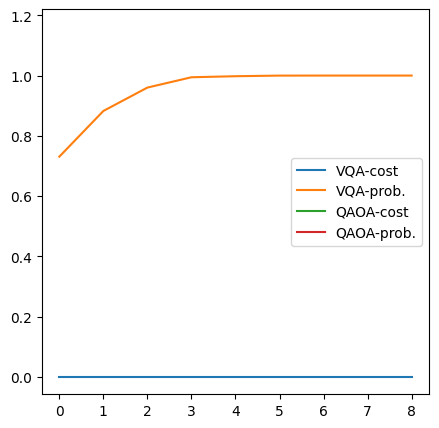

In [48]:
# N.B. Because the normalization is done w. respect to the "allowed states (w. k ones)" QAOA has cost above 1.
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot([it for it in range(len(CP_z_phase_costs))], CP_z_phase_costs, label='VQA-cost')
ax.plot([it for it in range(len(CP_z_phase_probs))], CP_z_phase_probs, label='VQA-prob.')
ax.plot([it for it in range(len(NORMAL_costs))], NORMAL_costs, label='QAOA-cost')
ax.plot([it for it in range(len(NORMAL_probs))], NORMAL_probs, label='QAOA-prob.')

#ax.set_xlim(0,len(CP_z_phase_costs))
#ax.hlines(0,0,len(CP_z_phase_costs),lw=1,linestyles='dashed',colors='k')
ax.legend(loc='best')
plt.show()